In [169]:
import opendatasets as od
import pandas as pd
import cv2
import glob
import numpy as np
from skimage.io import imshow
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import data, io, filters, feature

In [170]:
od.download("https://www.kaggle.com/saurabhbagchi/ship-and-iceberg-images")

Skipping, found downloaded files in "./ship-and-iceberg-images" (use force=True to force download)


In [171]:
import os
for dirname, _, filenames in os.walk('/home/apprenant/PycharmProjects/ClimateProject---E3/ship-and-iceberg-images/input_data.npz'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

 # Load the data

In [172]:
npz = np.load('/home/apprenant/PycharmProjects/ClimateProject---E3/Data analysis/ship-and-iceberg-images/input_data.npz')

X_train = npz['X_train']
Y_train = npz['Y_train']
del npz

print('We have {} examples to work with'.format(Y_train.shape[0]))


We have 4113 examples to work with


In [173]:
print('shape of picture: {}'.format(X_train.shape))

shape of picture: (4113, 75, 75, 3)


# Prepare data & analyse

## Ship analysis

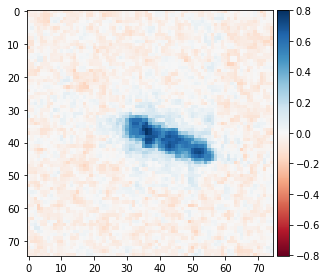

This is: Ship


In [228]:
ix = 100#0-4112
imshow(np.squeeze(X_train[ix,:,:,2]))#Looking at the combined channel
plt.show()
labels = ['Ship','Iceberg']  #0 is no iceberg(ship) and 1 is iceberg
print ('This is:',labels[int(Y_train[ix])])

In [229]:
def imageHistG(image):
    _, axis = plt.subplots(ncols=2, figsize=(12, 3))
    if (image.ndim == 2):
        # Grascale Image
        axis[0].imshow(image, cmap=plt.get_cmap('gray'))
        axis[1].set_title('Histogram')
        axis[0].set_title('Grayscale Image')
        hist = exposure.histogram(image)
        axis[1].plot(hist[0])

In [230]:
def imageHist(image):
    _, axis = plt.subplots(ncols=2, figsize=(12, 3))
    if (image.ndim == 2):
        # Color image
        axis[0].imshow(image, cmap='jet')
        axis[1].set_title('Histogram')
        axis[0].set_title('Colored Image')
        rgbcolors = ['red', 'green', 'blue']
        for i, mycolor in enumerate(rgbcolors):
            axis[1].plot(exposure.histogram(image[...,i])[0], color=mycolor)

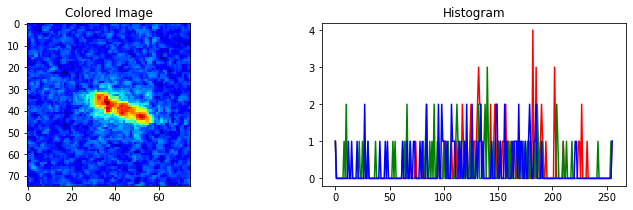

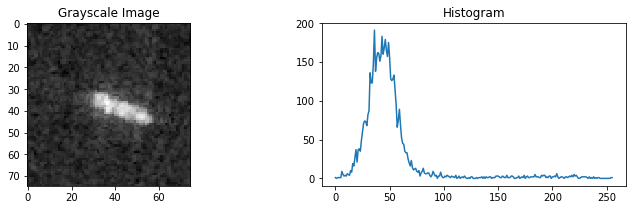

In [231]:
ix = 100
imageHist(X_train[ix,:,:,2])
imageHistG(X_train[ix,:,:,2])

In [ ]:
def histGrayScale(img, _xlim=255, _ylim=2400):
    _, axes = plt.subplots(ncols=2, figsize=(12, 3))
    ax = axes.ravel()
    ax[0].imshow(img, cmap=plt.get_cmap('gray'))
    ax[0].set_title('Image')
    hist = exposure.histogram(img)
    ax[1].plot(hist[0])
    # to provide a better display we just change the plot display
    ax[1].set_xlim([0, _xlim])
    ax[1].set_ylim([0, _ylim])
histGrayScale(X_train[ix,:,:,2])

## Iceberg analysis

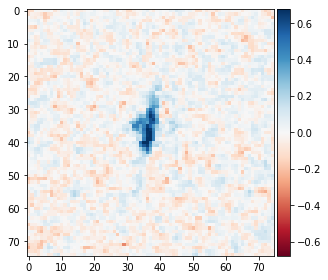

This is: Iceberg


In [219]:
ix1 = 110 #0-4112
imshow(np.squeeze(X_train[ix1,:,:,2]))#Looking at the combined channel
plt.show()
labels = ['Ship','Iceberg']  #0 is no iceberg(ship) and 1 is iceberg
print ('This is:',labels[int(Y_train[ix])])

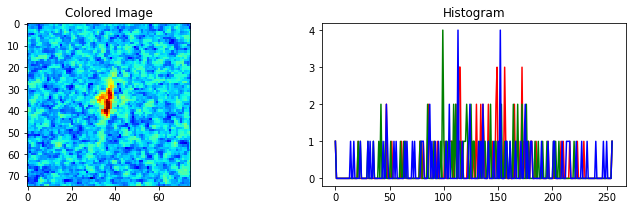

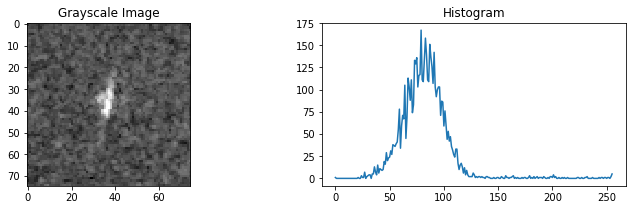

In [232]:
ix = 110
imageHist(X_train[ix,:,:,2])
imageHistG(X_train[ix,:,:,2])

# ANALYSE RGB LAYER

In [187]:
def RGBStats(image): 
    colors = [] 
    for i in range(0, 3): 
        max_color =np.max(image[:,:,i]) 
        min_color =np.min(image[:,:,i]) 
        mean_color = np.mean(image[:,:,i]) 
        median_color = np.median(image[:,:,i]) 
        row = (min_color, max_color, mean_color, median_color)
        colors.append(row)
    return pd.DataFrame(colors,  
                        index = ['Red', ' Green', 'Blue'], 
                        columns = ['Min', 'Max', 'Mean', 'Median'])
 
RGBStats(X_train)

,Min,Max,Mean,Median
Red,-0.613423,0.718828,-0.013360,-0.012173
Green,-0.643982,0.724928,-0.013464,-0.012064
Blue,-0.615498,0.724928,-0.013331,-0.011992


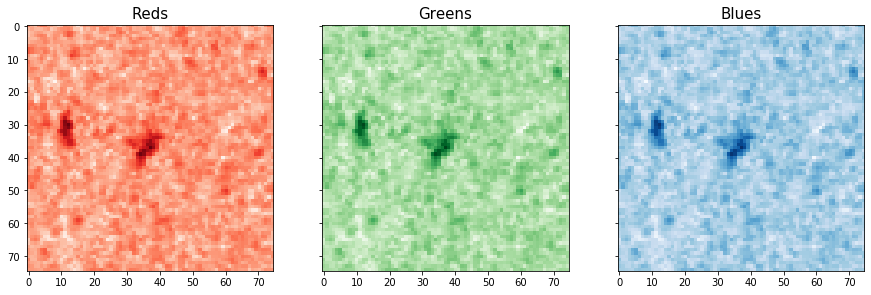

In [188]:
rgb = ['Reds','Greens','Blues'] 
_, axes = plt.subplots(1, 3, figsize=(15,5), sharey = True) 
for i in range(3): 
   axes[i].imshow(X_train[ix,:,:,2], cmap = rgb[i]) 
   axes[i].set_title(rgb[i], fontsize = 15)

# DETECT

On peut ici observer que les icebergs sont en plusieurs parties. Cela peut aider pour la detection. On peut donc lors de la détection poser des limites de périmètres pour aider à réaliser la bonne détection

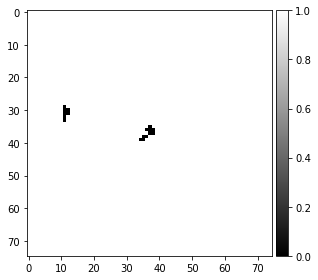

In [189]:
im = np.where(X_train[ix,:,:,2]>128/256, 0, 1)
imshow(im, cmap=plt.get_cmap('gray'));

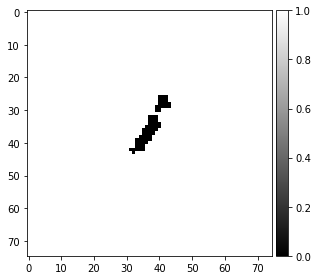

In [193]:
im = np.where(test2>128/256, 0, 1)
imshow(im, cmap=plt.get_cmap('gray'));

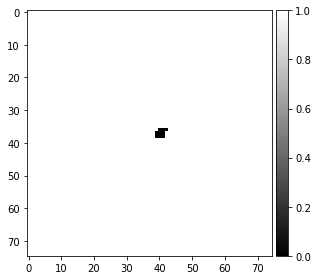

In [195]:
ix = 153 #0-4112
test2 = X_train[ix,:,:,2]
im = np.where(test2>128/256, 0, 1)
imshow(im, cmap=plt.get_cmap('gray'));

# REGARDER PLUS EN DÉTAILS CERTAINES CARACTÉRISTIQUES

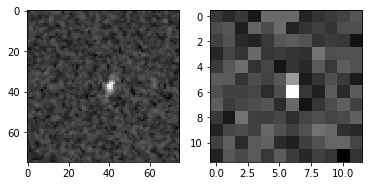

In [198]:
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage import exposure, transform
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

image_rescaled = transform.rescale(image=test2, scale=1.0 / 6.0, anti_aliasing=False, preserve_range=True)
_, axes = plt.subplots(ncols=2)
axes[0].imshow(test2, cmap=plt.get_cmap('gray'))
axes[1].imshow(image_rescaled, cmap=plt.get_cmap('gray'));

Text(0.5, 1.0, 'Thresholded Image')

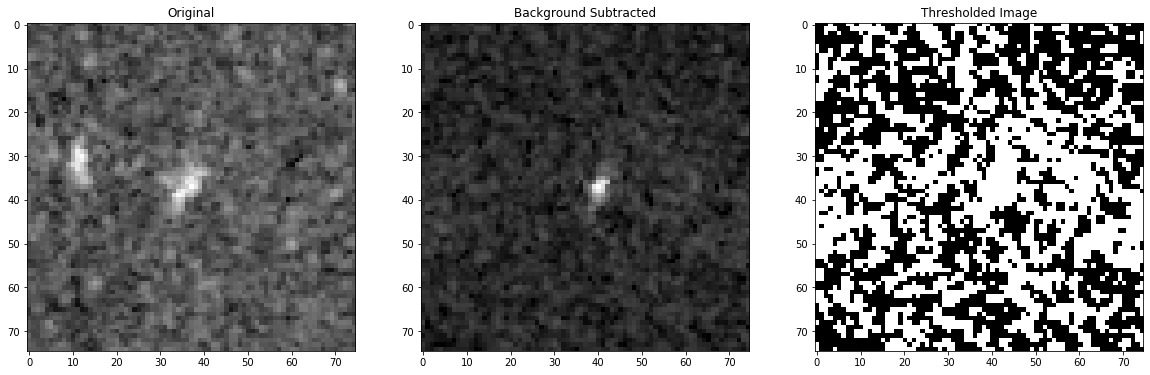

In [204]:
# defining a function for background subtraction
def subtract_background(image, radius=50, light_bg=False):
        #scikit image tophat function and structuring element need to be imported
        from skimage.morphology import white_tophat, black_tophat, disk 
        
        # this structuring element determines the size of background subtraction
        str_el = disk(radius)
        
        if light_bg:
            # the tophat function needs the image as well as the structuring element
            return black_tophat(image, str_el)
        
        else:
            return white_tophat(image, str_el)

# calling the function        
b_sub_triboium = subtract_background(test2,15)        

# thresholding with previous function
thresh_b_sub_trib = median_and_otsutresh(b_sub_triboium)

# plotting-------------------------------------------------------------
# This time we want three plots so we need to change the axes and values accordingly!
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize =(20,20))

ax1.imshow(tribolium)
ax1.set_title('Original')

ax2.imshow(b_sub_triboium) 
ax2.set_title('Background Subtracted')

ax3.imshow(thresh_b_sub_trib)
ax3.set_title('Thresholded Image')


# CNN ALGRORITHME

In [19]:
from tensorflow.keras.layers import Input

# We have 2 inputs, 1 for each picture
left_input = Input((75,75,3))
right_input = Input((75,75,3))

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Conv2D, Flatten, Dense

# We will use 2 instances of 1 network for this task
base_network = Sequential([
    Conv2D(5,3, input_shape=(75,75,3)),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(5,3),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    Flatten(),
    Dense(18),
    Activation('sigmoid')
])

In [116]:
# Connect both left and right input to the same network
# Remember, they have the same weights
processed_a = base_network(left_input)
processed_b = base_network(right_input)

In [29]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

# Getting the L1 Distance between the 2 encodings
L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))

# Add the distance function to the network
L1_distance = L1_layer([processed_a, processed_b])

In [30]:
from tensorflow.keras.models import Model

prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

In [31]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(0.001, decay=2.5e-4)

siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

In [32]:
siamese_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 18)           6912        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 18)           0           sequential_1[0][0]           

In [33]:
import random

# First let's separate the dataset from 1 matrix to a list of matricies
image_list = np.split(X_train[:1000],1000)
label_list = np.split(Y_train[:1000],1000)

left_input = []
right_input = []
targets = []

#Number of pairs per image
pairs = 5
#Let's create the new dataset to train on
for i in range(len(label_list)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i: #Make sure it's not comparing to itself
            compare_to = random.randint(0,999)
        left_input.append(image_list[i])
        right_input.append(image_list[compare_to])
        if label_list[i] == label_list[compare_to]:# They are the same
            targets.append(1.)
        else:# Not the same
            targets.append(0.)
            
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))

iceimage = X_train[101]
test_left = []
test_right = []
test_targets = []

for i in range(Y_train.shape[0]-1000):
    test_left.append(iceimage)
    test_right.append(X_train[i+1000])
    test_targets.append(Y_train[i+1000])

test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets))

In [41]:
test=siamese_net.fit([left_input,right_input], targets,
          batch_size=16,
          epochs=10,
          verbose=1,
          validation_data=([test_left,test_right],test_targets))

Epoch 1/10
313/313 [==============================] - 11s 34ms/step - loss: 0.4376 - accuracy: 0.8112 - val_loss: 0.5370 - val_accuracy: 0.7629
Epoch 2/10
313/313 [==============================] - 10s 32ms/step - loss: 0.4208 - accuracy: 0.8168 - val_loss: 0.5236 - val_accuracy: 0.7732
Epoch 3/10
313/313 [==============================] - 10s 31ms/step - loss: 0.4097 - accuracy: 0.8236 - val_loss: 0.5221 - val_accuracy: 0.7739
Epoch 4/10
313/313 [==============================] - 10s 31ms/step - loss: 0.3970 - accuracy: 0.8324 - val_loss: 0.5686 - val_accuracy: 0.7607
Epoch 5/10
313/313 [==============================] - 10s 33ms/step - loss: 0.3884 - accuracy: 0.8370 - val_loss: 0.5365 - val_accuracy: 0.7681
Epoch 6/10
313/313 [==============================] - 10s 33ms/step - loss: 0.3801 - accuracy: 0.8408 - val_loss: 0.6349 - val_accuracy: 0.7324
Epoch 7/10
313/313 [==============================] - 10s 32ms/step - loss: 0.3718 - accuracy: 0.8486 - val_loss: 0.6153 - val_accuracy:

# ÉVALUATION

In [43]:


#create a dataframe of the model training history
results = pd.DataFrame(test.history)
results.head()



,loss,accuracy,val_loss,val_accuracy
0,0.437606,0.8112,0.536956,0.762930
1,0.420762,0.8168,0.523641,0.773209
2,0.409750,0.8236,0.522135,0.773852
3,0.396957,0.8324,0.568600,0.760681
4,0.388359,0.8370,0.536473,0.768069


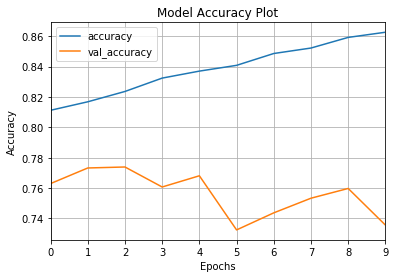

In [44]:
#plot the accuracy over the training and test set
results[['accuracy','val_accuracy']].plot()
plt.title('Model Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

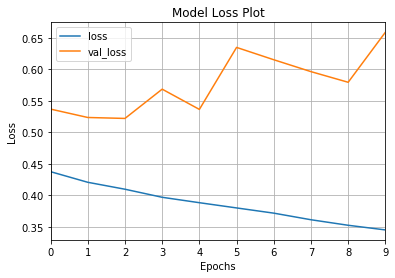

In [45]:
#plot the loss over the training and test set
results[['loss','val_loss']].plot()
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

https://biapol.github.io/blog/ryan_savill/02_intro_to_skimage/

https://www.kaggle.com/saurabhbagchi/ship-and-iceberg-dataset-for-starters